In [2]:
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from sklearn.utils import shuffle
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from Bio import SeqIO
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, Dropout, MaxPooling1D, Flatten, Dense
import os
import random


In [3]:
# Function to set seeds for reproducibility
def set_seed(seed_value=42):
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

# Set seed for reproducibility
set_seed(42)

# Set deterministic operations in TensorFlow
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [4]:
train_x = []
train_y = []
r_test_x = []
r_test_y = []
posit_1 = 1;
negat_0 = 0;
win_size = 33 # actual window size
win_size_kernel = int(win_size/2 + 1)


# define universe of possible input values
alphabet = 'ARNDCQEGHILKMFPSTWYV-'

# define a mapping of chars to integers
char_to_int = dict((c, i) for i, c in enumerate(alphabet))
int_to_char = dict((i, c) for i, c in enumerate(alphabet))

# TRAIN DATASET -------------------------------------------------------------
#for positive sequence
def inner1():
    #Input
    data = seq_record.seq
    #rint(data) 
    # integer encode input data
    for char in data:
        if char not in alphabet:
            return
    integer_encoded = [char_to_int[char] for char in data]
    train_x.append(integer_encoded)
    train_y.append(posit_1)
for seq_record in SeqIO.parse("../data/train/fasta/positive_sites.fasta", "fasta"): # training data positive
    inner1()
#for negative sequence
def inner2():
    #Input
    data = seq_record.seq
    #print(data) 
    # integer encode input data
    for char in data:
        if char not in alphabet:
            return
    integer_encoded = [char_to_int[char] for char in data]
    train_x.append(integer_encoded)
    train_y.append(negat_0)
for seq_record in SeqIO.parse("../data/train/fasta/negative_sites.fasta", "fasta"): # training data negative
    inner2()
# Changing to array (matrix)    
train_x = np.array(train_x)
train_y = np.array(train_y)


#-------------------------TEST DATASET----------------------------------------
#for positive sequence
def innertest1():
    #Input
    data = seq_record.seq
    #rint(data) 
    # integer encode input data
    for char in data:
        if char not in alphabet:
            return
    integer_encoded = [char_to_int[char] for char in data]
    r_test_x.append(integer_encoded)
    r_test_y.append(posit_1)
for seq_record in SeqIO.parse("../data/test/fasta/test_positive_sites.fasta", "fasta"): # test positive
    innertest1()
#for negative sequence
def innertest2():
    #Input
    data = seq_record.seq
    #print(data) 
    # integer encode input data
    for char in data:
        if char not in alphabet:
            return
    integer_encoded = [char_to_int[char] for char in data]
    r_test_x.append(integer_encoded)
    r_test_y.append(negat_0)
for seq_record in SeqIO.parse("../data/test/fasta/test_negative_sites.fasta", "fasta"): # test negative
    innertest2()

r_test_x = np.array(r_test_x)
r_test_y = np.array(r_test_y)


# epochs = 100
# num_classes = 2
# batch_size = 256
# optimize_2 = tf.keras.optimizers.Adam()

# loss_2 = tf.keras.losses.binary_crossentropy

# test_size = 0.2
seed = 3

X_train = train_x
y_train = train_y

X_test = r_test_x
y_test = r_test_y


print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(9499, 33)
(9499,)
(3226, 33)
(3226,)


In [5]:
train_positive_pt5 = pd.read_csv("../data/train/features/train_positive_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]
train_negative_pt5 = pd.read_csv("../data/train/features/train_negative_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]
test_positive_pt5 = pd.read_csv("../data/test/features/test_positive_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]
test_negative_pt5 = pd.read_csv("../data/test/features/test_negative_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]


# create labels
train_positive_labels = np.ones(train_positive_pt5.shape[0])
train_negative_labels = np.zeros(train_negative_pt5.shape[0])
test_positive_labels = np.ones(test_positive_pt5.shape[0])
test_negative_labels = np.zeros(test_negative_pt5.shape[0])

# stack positive and negative data together
X_train_pt5 = np.vstack((train_positive_pt5,train_negative_pt5))
X_test_pt5 = np.vstack((test_positive_pt5,test_negative_pt5))
y_train_pt5 = np.concatenate((train_positive_labels, train_negative_labels), axis = 0)
y_test_pt5 = np.concatenate((test_positive_labels, test_negative_labels), axis = 0)

# # shuffle X and y together
# X_train_pt5, y_train_pt5 = shuffle(X_train_pt5, y_train_pt5)
# X_test_pt5, y_test_pt5 = shuffle(X_test_pt5, y_test_pt5)
print(X_train_pt5.shape)
print(y_train_pt5.shape)
print(X_test_pt5.shape)
print(y_test_pt5.shape)

(9499, 1024)
(9499,)
(3226, 1024)
(3226,)


In [6]:
from sklearn.model_selection import train_test_split

# Define the split ratio and random state for reproducibility
split_ratio = 0.1
random_state = 42

# Perform the split on the smaller dataset (X_train_pt5, y_train_pt5)
X_train_pt5, X_val_pt5, y_train_pt5, y_val_pt5 = train_test_split(
    X_train_pt5, y_train_pt5, test_size=split_ratio, random_state=random_state, stratify=y_train_pt5)

# Use the same indices to split the larger dataset (X_train, y_train)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=split_ratio, random_state=random_state, stratify=y_train)

# Now, both X_val_pt5 and X_val correspond to the same split in y_train_pt5 and y_train
print( y_val[:10])
print( y_val_pt5[:10])

# X_test = X_test[:2000]
# y_test = y_test[:2000]
# X_test_pt5 = X_test_pt5[:2000]
# y_test_pt5 = y_test_pt5[:2000]

[0 0 0 1 1 0 0 1 1 1]
[0. 0. 0. 1. 1. 0. 0. 1. 1. 1.]


In [7]:
def plot(history):
    # learning curves of model accuracy
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()

In [8]:
from sklearn.metrics import accuracy_score, matthews_corrcoef, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
def evaluate_model(model, X_val = None, X_val_pt5 = None, y_val=None):
    y_true = y_val
    # Predict probabilities (or logits if using `from_logits=True`).
    if X_val_pt5 is None:
        y_pred_probs = model.predict(X_val)
    elif X_val is None:
        y_pred_probs = model.predict(X_val_pt5)
    else:
        y_pred_probs = model.predict([X_val, X_val_pt5])

    # Convert probabilities/logits to binary predictions (threshold = 0.5).
    y_pred = (y_pred_probs > 0.5).astype(int)

    # If y_true is one-hot encoded, convert it to binary format
    if len(y_true.shape) > 1 and y_true.shape[1] > 1:  # Check if y_true is one-hot encoded
        y_true = np.argmax(y_true, axis=1)  # Convert one-hot encoded y_true to binary labels

    # Ensure y_pred is also 1D
    if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:
        y_pred = np.argmax(y_pred, axis=1)  # Convert y_pred to binary labels if necessary

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Compute Specificity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    # Print the results
    print(f'Accuracy: {accuracy}')
    print(f'MCC: {mcc}')
    print(f'AUC: {auc}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'Specificity: {specificity}')
    print(f'F1: {f1}')

    return accuracy, mcc, auc, precision, recall, specificity, f1

Conv1D model:

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4840 - loss: 0.6960 - val_accuracy: 0.5168 - val_loss: 0.6929
Epoch 2/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5027 - loss: 0.6948 - val_accuracy: 0.5368 - val_loss: 0.6922
Epoch 3/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5109 - loss: 0.6932 - val_accuracy: 0.5421 - val_loss: 0.6916
Epoch 4/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5201 - loss: 0.6907 - val_accuracy: 0.5484 - val_loss: 0.6908
Epoch 5/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5320 - loss: 0.6895 - val_accuracy: 0.5600 - val_loss: 0.6897
Epoch 6/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5426 - loss: 0.6876 - val_accuracy: 0.5747 - val_loss: 0.6880
Epoch 7/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5555 - loss: 0.6871 - val_accuracy: 0.6000 - val_loss: 0.6858
Epoch 8/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5806 - loss: 0.6819 - val_accu

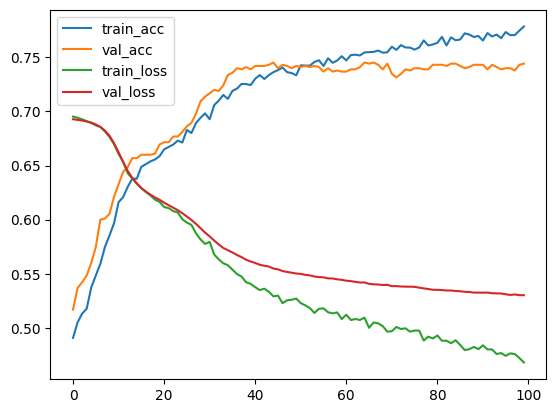

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy: 0.7442105263157894
MCC: 0.49172852794318495
AUC: 0.7442105263157894
Precision: 0.7188679245283018
Recall: 0.8021052631578948
Specificity: 0.6863157894736842
F1: 0.7582089552238805
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.6909485430874147
MCC: 0.25808220459292724
AUC: 0.7292623067422349
Precision: 0.17253521126760563
Recall: 0.7747035573122529
Specificity: 0.6838210561722167
F1: 0.2822174226061915


(0.6909485430874147,
 0.25808220459292724,
 0.7292623067422349,
 0.17253521126760563,
 0.7747035573122529,
 0.6838210561722167,
 0.2822174226061915)

In [32]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, Dropout, MaxPooling1D, Flatten, Dense

def conv1d_model():
    
    model = Sequential()
    
    # Embedding layer
    model.add(Embedding(64, 21, input_length=33))
    
    # Conv1D and Dropout layers
    model.add(Conv1D(64, kernel_size=17, activation='relu', kernel_initializer='he_normal', padding='valid'))
    model.add(Dropout(0.6))
    
    model.add(Conv1D(128, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same'))
    model.add(Dropout(0.6))
    
    # MaxPooling, Flatten, and Dense layers
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    
    # model.add(Dense(768, activation='relu', kernel_initializer='he_normal'))
    # model.add(Dropout(0.5))
    
    # model.add(Dense(256, activation='relu', kernel_initializer='he_normal'))
    # model.add(Dropout(0.5))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])
    
    return model


conv1d_model = conv1d_model()
conv1d_model.summary()

# Fit the model
history = conv1d_model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1,
                            validation_data=(X_val, y_val), 
                            callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]) 

plot(history)

# Evaluate the model
evaluate_model(conv1d_model, X_val=X_val, y_val=y_val)
evaluate_model(conv1d_model, X_val_pt5=X_test, y_val=y_test)


Solo Inception Model:

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_34      │ (None, 33)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_19        │ (None, 33, 21)    │      1,344 │ input_layer_34[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_25    │ (None, 33, 21)    │          0 │ embedding_19[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_57 (Conv1D)  │ (None, 33, 32)    │        704 │ embedding_19[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_58 (Conv1D)  │ (None, 33, 32)    │      2,048 │ embedding_19[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_59 (Conv1D)  │ (None, 33, 32)    │      3,392 │ embedding_19[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_60 (Conv1D)  │ (None, 33, 32)    │        704 │ max_pooling1d_25… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_17      │ (None, 33, 128)   │          0 │ conv1d_57[0][0],  │
│ (Concatenate)       │                   │            │ conv1d_58[0][0],  │
│                     │                   │            │ conv1d_59[0][0],  │
│                     │                   │            │ conv1d_60[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_26    │ (None, 16, 128)   │          0 │ concatenate_17[0… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_19          │ (None, 2048)      │          0 │ max_pooling1d_26… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_87 (Dense)    │ (None, 16)        │     32,784 │ flatten_19[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_50          │ (None, 16)        │          0 │ dense_87[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_88 (Dense)    │ (None, 16)        │        272 │ dropout_50[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_51          │ (None, 16)        │          0 │ dense_88[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_89 (Dense)    │ (None, 1)         │         17 │ dropout_51[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 41,265 (161.19 KB)

 Trainable params: 41,265 (161.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4994 - loss: 0.6931 - val_accuracy: 0.5168 - val_loss: 0.6923
Epoch 2/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5140 - loss: 0.6926 - val_accuracy: 0.5758 - val_loss: 0.6914
Epoch 3/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5259 - loss: 0.6913 - val_accuracy: 0.6221 - val_loss: 0.6890
Epoch 4/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5667 - loss: 0.6882 - val_accuracy: 0.6421 - val_loss: 0.6820
Epoch 5/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5857 - loss: 0.6812 - val_accuracy: 0.6705 - val_loss: 0.6695
Epoch 6/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6054 - loss: 0.6695 - val_accuracy: 0.6811 - val_loss: 0.6519
Epoch 7/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6260 - loss: 0.6574 - val_accuracy: 0.6832 - val_loss: 0.6338
Epoch 8/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6390 - loss: 0.6428 - 

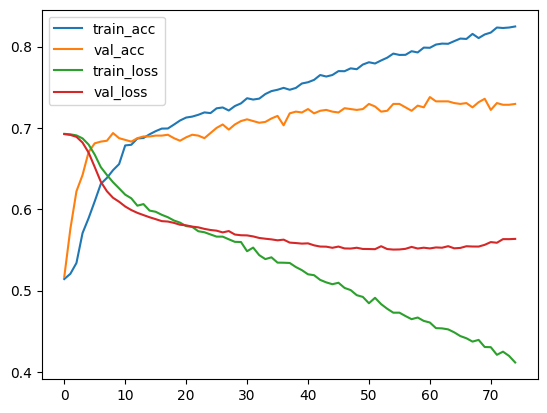

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.7294736842105263
MCC: 0.4593965495206998
AUC: 0.7294736842105263
Precision: 0.719758064516129
Recall: 0.751578947368421
Specificity: 0.7073684210526315
F1: 0.7353244078269825
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.6890886546807191
MCC: 0.23921239203192896
AUC: 0.7119802863452229
Precision: 0.16637010676156583
Recall: 0.7391304347826086
Specificity: 0.6848301379078372
F1: 0.2716049382716049


(0.6890886546807191,
 0.23921239203192896,
 0.7119802863452229,
 0.16637010676156583,
 0.7391304347826086,
 0.6848301379078372,
 0.2716049382716049)

In [62]:
def inception_module(input_tensor):
    # Branch 1: Conv1D with kernel size 1
    branch1 = Conv1D(32, kernel_size=1, activation='relu', padding='same')(input_tensor)

    # Branch 2: Conv1D with kernel size 3
    branch2 = Conv1D(32, kernel_size=3, activation='relu', padding='same')(input_tensor)

    # Branch 3: Conv1D with kernel size 5
    branch3 = Conv1D(32, kernel_size=5, activation='relu', padding='same')(input_tensor)

    # Branch 7: MaxPooling + Conv1D with kernel size 1
    branch7 = MaxPooling1D(pool_size=3, strides=1, padding='same')(input_tensor)
    branch7 = Conv1D(32, kernel_size=1, activation='relu', padding='same')(branch7)

    # Concatenate all branches
    output = Concatenate()([branch1, branch2, branch3, branch7])
    return output

def build_solo_inception_model(input_shape_conv):
    # Conv1D branch for sequence data
    conv_input = Input(shape=input_shape_conv)

    # Embedding layer
    x_conv = Embedding(input_dim=64, output_dim=21, input_length=input_shape_conv[0])(conv_input)

    # Apply Inception module instead of Conv1D
    x_conv = inception_module(x_conv)

    # MaxPooling and Flatten layers
    x_conv = MaxPooling1D(pool_size=2)(x_conv)
    x_conv = Flatten()(x_conv)

    # Dense layer for sequence features
    x_conv = Dense(16, activation='relu')(x_conv)
    x_conv = Dropout(0.3)(x_conv)

    # Output layer
    x = Dense(16, activation='relu')(x_conv)
    x = Dropout(0.3)(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    # Build model
    model = Model(inputs=conv_input, outputs=output_layer)

    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model

# Define the solo Inception model with Conv1D input shape (33,)
solo_inception_model = build_solo_inception_model((33,))
solo_inception_model.summary()

# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Fit the solo Inception model
history = solo_inception_model.fit(X_train, y_train, epochs=1000, batch_size=64, verbose=1, callbacks=[early_stopping], validation_data=(X_val, y_val))

# Plot history
plot(history)

# Evaluate the model
evaluate_model(solo_inception_model, X_val=X_val, X_val_pt5=None, y_val=y_val)
evaluate_model(solo_inception_model, X_val=X_test, X_val_pt5=None, y_val=y_test)


ANN model:

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,657 (260.38 KB)

 Trainable params: 66,657 (260.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5235 - loss: 0.6978 - val_accuracy: 0.6053 - val_loss: 0.6637
Epoch 2/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6317 - loss: 0.6515 - val_accuracy: 0.6484 - val_loss: 0.6289
Epoch 3/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6789 - loss: 0.6117 - val_accuracy: 0.6684 - val_loss: 0.6026
Epoch 4/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6993 - loss: 0.5844 - val_accuracy: 0.7042 - val_loss: 0.5865
Epoch 5/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7201 - loss: 0.5610 - val_accuracy: 0.7074 - val_loss: 0.5744
Epoch 6/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7259 - loss: 0.5493 - val_accuracy: 0.7105 - val_loss: 0.5658
Epoch 7/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7302 - loss: 0.5365 - val_accuracy: 0.7116 - val_loss: 0.5598
Epoch 8/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7404 - loss: 0.5256 - val_accuracy: 0.

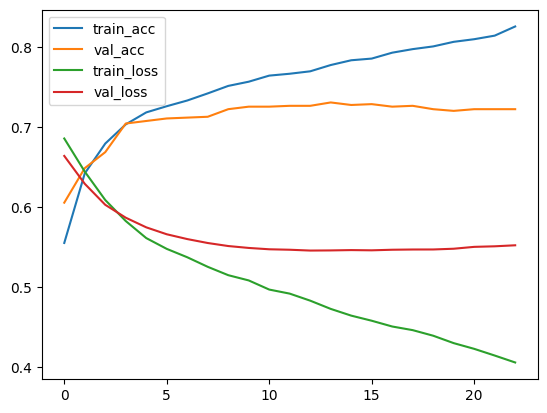

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.7263157894736842
MCC: 0.4526476287877266
AUC: 0.7263157894736841
Precision: 0.7282377919320594
Recall: 0.7221052631578947
Specificity: 0.7305263157894737
F1: 0.7251585623678647
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step
Accuracy: 0.7234965902045877
MCC: 0.24760823838741322
AUC: 0.7125672554971023
Precision: 0.1782477341389728
Recall: 0.6996047430830039
Specificity: 0.7255297679112008
F1: 0.2841091492776886


(0.7234965902045877,
 0.24760823838741322,
 0.7125672554971023,
 0.1782477341389728,
 0.6996047430830039,
 0.7255297679112008,
 0.2841091492776886)

In [36]:
def ANN():
    ann_input = Input(shape=(1024,))

    # Hidden layers
    x = Dense(32, activation='relu')(ann_input)
    x = Dropout(0.2)(x)
    x = Dense(8, activation='relu')(x)

    # Output layer
    ann_output = Dense(1, activation='sigmoid')(x)

    # Create the model
    model = Model(ann_input, ann_output)

    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model

ann_model = ANN()
ann_model.summary()

# Fit the model
history = ann_model.fit(X_train_pt5, y_train_pt5, epochs=30, batch_size=64, verbose=1,
                        validation_data=(X_val_pt5, y_val_pt5), 
                        callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

plot(history)

# Evaluate the model
evaluate_model(ann_model, X_val=None, X_val_pt5=X_val_pt5, y_val=y_val_pt5)
evaluate_model(ann_model, X_val=None, X_val_pt5=X_test_pt5, y_val=y_test_pt5)

Simple Model :

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24      │ (None, 33)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_12        │ (None, 33, 21)    │      1,344 │ input_layer_24[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 29, 32)    │      3,392 │ embedding_12[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_12    │ (None, 14, 32)    │          0 │ conv1d_14[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_12          │ (None, 448)       │          0 │ max_pooling1d_12… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_25      │ (None, 1024)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_61 (Dense)    │ (None, 16)        │      7,184 │ flatten_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_63 (Dense)    │ (None, 32)        │     32,800 │ input_layer_25[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_34          │ (None, 16)        │          0 │ dense_61[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_35          │ (None, 32)        │          0 │ dense_63[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_62 (Dense)    │ (None, 8)         │        136 │ dropout_34[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_64 (Dense)    │ (None, 8)         │        264 │ dropout_35[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 16)        │          0 │ dense_62[0][0],   │
│ (Concatenate)       │                   │            │ dense_64[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_65 (Dense)    │ (None, 1)         │         17 │ concatenate_8[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 45,137 (176.32 KB)

 Trainable params: 45,137 (176.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5466 - loss: 0.6883 - val_accuracy: 0.5863 - val_loss: 0.6689
Epoch 2/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6315 - loss: 0.6527 - val_accuracy: 0.6442 - val_loss: 0.6345
Epoch 3/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6668 - loss: 0.6206 - val_accuracy: 0.6811 - val_loss: 0.6101
Epoch 4/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6894 - loss: 0.5965 - val_accuracy: 0.6916 - val_loss: 0.5927
Epoch 5/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7066 - loss: 0.5771 - val_accuracy: 0.7105 - val_loss: 0.5799
Epoch 6/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7159 - loss: 0.5656 - val_accuracy: 0.7168 - val_loss: 0.5698
Epoch 7/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7213 - loss: 0.5506 - val_accuracy: 0.7200 - val_loss: 0.5607
Epoch 8/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7324 - loss: 0.5399 - val_accu

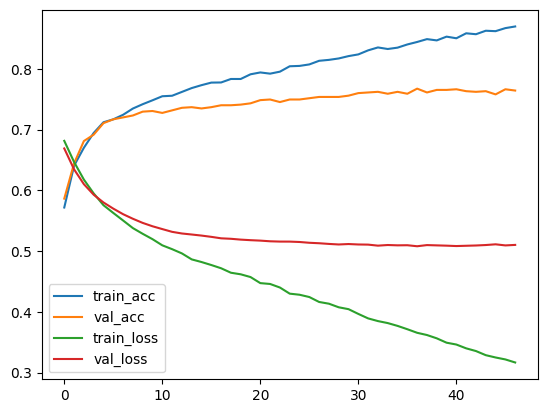

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.7673684210526316
MCC: 0.5351651456117386
AUC: 0.7673684210526317
Precision: 0.7785087719298246
Recall: 0.7473684210526316
Specificity: 0.7873684210526316
F1: 0.7626208378088077
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.7650340979541228
MCC: 0.3116438906170306
AUC: 0.7586087701035273
Precision: 0.21468926553672316
Recall: 0.7509881422924901
Specificity: 0.7662293979145645
F1: 0.3339191564147627


(0.7650340979541228,
 0.3116438906170306,
 0.7586087701035273,
 0.21468926553672316,
 0.7509881422924901,
 0.7662293979145645,
 0.3339191564147627)

In [53]:
import tensorflow as tf
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Concatenate, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

def round_layer(x):
    return tf.math.round(x)  # Custom layer to round values to the nearest integers

def build_simple_model(input_shape_conv, input_shape_ann):
    # Conv1D branch for sequence data
    conv_input = Input(shape=input_shape_conv)

    # Embedding layer
    x_conv = Embedding(input_dim=64, output_dim=21, input_length=input_shape_conv[0])(conv_input)

    # Simple Conv1D + MaxPooling layer
    x_conv = Conv1D(32, kernel_size=5, activation='relu', kernel_initializer='he_normal')(x_conv)
    x_conv = MaxPooling1D(pool_size=2)(x_conv)
    x_conv = Flatten()(x_conv)

    # Simple Dense layer for sequence features with integer output
    x_conv = Dense(16, activation='relu', kernel_initializer='he_normal')(x_conv)
    x_conv = Dropout(0.2)(x_conv)
    x_conv = Dense(8, activation='relu', kernel_initializer='he_normal')(x_conv)  # Final integer size

    # ANN branch for prot_t5 embeddings
    ann_input = Input(shape=(input_shape_ann,))

    # Simple Dense layer for ANN features with integer output
    x_ann = Dense(32, activation='relu')(ann_input)
    x_ann = Dropout(0.2)(x_ann)
    x_ann = Dense(8, activation='relu')(x_ann)  # Final integer size


    # Concatenate Conv1D and ANN branches
    combined = Concatenate()([x_conv, x_ann])

    # Output layer
    output_layer = Dense(1, activation='sigmoid')(combined)

    # Build model
    model = Model(inputs=[conv_input, ann_input], outputs=output_layer)

    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model

# Define the model with Conv1D input shape (33,) and ANN input shape 1024
simple_model = build_simple_model((33,), 1024)
simple_model.summary()

# Fit the simple model
history = simple_model.fit([X_train, X_train_pt5], y_train, epochs=100, batch_size=64,
                                 verbose=1, 
                                 validation_data=([X_val, X_val_pt5], y_val),
                                 callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
                                )

plot(history)

# simple_model.load_weights('models/simple_model.weights.h5')

# Evaluate the model
evaluate_model(simple_model, X_val, X_val_pt5, y_val)
evaluate_model(simple_model, X_test, X_test_pt5, y_test)




Inception+ANN Model :

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_41"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_69      │ (None, 33)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_37        │ (None, 33, 21)    │      1,344 │ input_layer_69[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_55    │ (None, 33, 21)    │          0 │ embedding_37[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_130 (Conv1D) │ (None, 33, 32)    │        704 │ embedding_37[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_131 (Conv1D) │ (None, 33, 32)    │      2,048 │ embedding_37[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_132 (Conv1D) │ (None, 33, 32)    │      3,392 │ embedding_37[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_133 (Conv1D) │ (None, 33, 32)    │      4,736 │ embedding_37[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_134 (Conv1D) │ (None, 33, 32)    │      6,080 │ embedding_37[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_135 (Conv1D) │ (None, 33, 32)    │      7,424 │ embedding_37[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_136 (Conv1D) │ (None, 33, 32)    │        704 │ max_pooling1d_55… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_46      │ (None, 33, 224)   │          0 │ conv1d_130[0][0], │
│ (Concatenate)       │                   │            │ conv1d_131[0][0], │
│                     │                   │            │ conv1d_132[0][0], │
│                     │                   │            │ conv1d_133[0][0], │
│                     │                   │            │ conv1d_134[0][0], │
│                     │                   │            │ conv1d_135[0][0], │
│                     │                   │            │ conv1d_136[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_56    │ (None, 16, 224)   │          0 │ concatenate_46[0… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_37          │ (None, 3584)      │          0 │ max_pooling1d_56… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_70      │ (None, 1024)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_164 (Dense)   │ (None, 16)        │     57,360 │ flatten_37[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_165 (Dense)   │ (None, 64)        │     65,600 │ input_layer_70[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_97          │ (None, 16)        │          0 │ dense_164[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_98          │ (None, 64)        │          0 │ dense_165[0][0]   │
│ (Dropout)           │                   │            │                 

 Total params: 149,473 (583.88 KB)

 Trainable params: 149,473 (583.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5397 - loss: 0.6870 - val_accuracy: 0.6453 - val_loss: 0.6500
Epoch 2/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6607 - loss: 0.6332 - val_accuracy: 0.6726 - val_loss: 0.6215
Epoch 3/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6838 - loss: 0.6026 - val_accuracy: 0.6832 - val_loss: 0.6003
Epoch 4/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7148 - loss: 0.5764 - val_accuracy: 0.7084 - val_loss: 0.5830
Epoch 5/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7210 - loss: 0.5570 - val_accuracy: 0.7126 - val_loss: 0.5660
Epoch 6/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7310 - loss: 0.5395 - val_accuracy: 0.7116 - val_loss: 0.5501
Epoch 7/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7499 - loss: 0.5179 - val_accuracy: 0.7232 - val_loss: 0.5389
Epoch 8/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7552 - loss: 0.5105 - val_accu

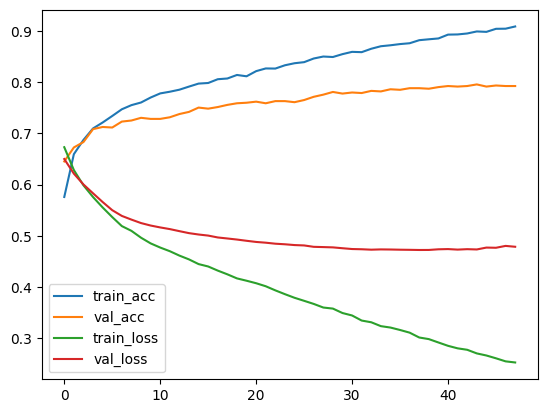

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Accuracy: 0.7884210526315789
MCC: 0.5768536104914537
AUC: 0.788421052631579
Precision: 0.7866108786610879
Recall: 0.791578947368421
Specificity: 0.7852631578947369
F1: 0.789087093389297
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.773403595784253
MCC: 0.345563325628821
AUC: 0.7866549937580516
Precision: 0.22963800904977374
Recall: 0.8023715415019763
Specificity: 0.7709384460141272
F1: 0.357080035180299


(0.773403595784253,
 0.345563325628821,
 0.7866549937580516,
 0.22963800904977374,
 0.8023715415019763,
 0.7709384460141272,
 0.357080035180299)

In [81]:
import tensorflow as tf
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Concatenate, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

def inception_module(input_tensor):
    # Branch 1: Conv1D with kernel size 1
    branch1 = Conv1D(32, kernel_size=1, activation='relu', padding='same')(input_tensor)

    # Branch 2: Conv1D with kernel size 3
    branch2 = Conv1D(32, kernel_size=3, activation='relu', padding='same')(input_tensor)

    # Branch 3: Conv1D with kernel size 5
    branch3 = Conv1D(32, kernel_size=5, activation='relu', padding='same')(input_tensor)

    # Branch 4: Conv1D with kernel size 7
    branch4 = Conv1D(32, kernel_size=7, activation='relu', padding='same')(input_tensor)

    # Branch 5: Conv1D with kernel size 9
    branch5 = Conv1D(32, kernel_size=9, activation='relu', padding='same')(input_tensor)

    # Branch 6: Conv1D with kernel size 11
    branch6 = Conv1D(32, kernel_size=11, activation='relu', padding='same')(input_tensor)

    # Branch 7: MaxPooling + Conv1D with kernel size 1
    branch7 = MaxPooling1D(pool_size=3, strides=1, padding='same')(input_tensor)
    branch7 = Conv1D(32, kernel_size=1, activation='relu', padding='same')(branch7)

    # Concatenate all branches
    output = Concatenate()([branch1, branch2, branch3, branch4, branch5, branch6, branch7])
    return output

def build_inception_model(input_shape_conv, input_shape_ann):
    # Conv1D branch for sequence data
    conv_input = Input(shape=input_shape_conv)

    # Embedding layer
    x_conv = Embedding(input_dim=64, output_dim=21, input_length=input_shape_conv[0])(conv_input)

    # Apply Inception module instead of Conv1D
    x_conv = inception_module(x_conv)

    # MaxPooling and Flatten layers
    x_conv = MaxPooling1D(pool_size=2)(x_conv)
    x_conv = Flatten()(x_conv)

    # Dense layer for sequence features
    x_conv = Dense(16, activation='relu')(x_conv)
    x_conv = Dropout(0.3)(x_conv)

    # ANN branch for prot_t5 embeddings
    ann_input = Input(shape=(input_shape_ann,))

    # Simple Dense layer for ANN features
    x_ann = Dense(64, activation='relu')(ann_input)
    x_ann = Dropout(0.3)(x_ann)

    # Concatenate Conv1D (Inception) and ANN branches
    combined = Concatenate()([x_conv, x_ann])

    # Output layer
    x = Dense(16, activation='relu')(combined)
    x = Dropout(0.3)(x)
    output_layer = Dense(1, activation='sigmoid')(combined)

    # Build model
    model = Model(inputs=[conv_input, ann_input], outputs=output_layer)

    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model

# Define the model with Conv1D input shape (33,) and ANN input shape 1024
inception_model = build_inception_model((33,), 1024)
inception_model.summary()


# Fit the Inception model
history = inception_model.fit([X_train, X_train_pt5], y_train, epochs=100, batch_size=64, verbose=1,
                               validation_data=([X_val, X_val_pt5], y_val),
                                 callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

plot(history)

# Evaluate the model
evaluate_model(inception_model, X_val, X_val_pt5, y_val)
evaluate_model(inception_model, X_test, X_test_pt5, y_test)


Load Saved Models :

In [82]:
simple_model = build_simple_model((33,), 1024)

inception_model = build_inception_model((33,), 1024)

simple_model.load_weights('models/simple_model_full_train.weights.h5')

inception_model.load_weights('models/inception_model_full_train.weights.h5')

evaluate_model(simple_model, X_test, X_test_pt5, y_test)

evaluate_model(inception_model, X_test, X_test_pt5, y_test)

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 28 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 44 variables. 
  saveable.load_own_variables(weights_store.get(inner_pa

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 0.7625542467451953
MCC: 0.3325323587003211
AUC: 0.7789605793378882
Precision: 0.2202835332606325
Recall: 0.7984189723320159
Specificity: 0.7595021863437605
F1: 0.3452991452991453
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 0.78735275883447
MCC: 0.35285985220860794
AUC: 0.7869906895923655
Precision: 0.2394705174488568
Recall: 0.7865612648221344
Specificity: 0.7874201143625967
F1: 0.3671586715867159


(0.78735275883447,
 0.35285985220860794,
 0.7869906895923655,
 0.2394705174488568,
 0.7865612648221344,
 0.7874201143625967,
 0.3671586715867159)

Cross Validation :

In [138]:
from sklearn.model_selection import KFold
import numpy as np

# Assuming your input data is X_train (Conv1D input) and X_train_pt5 (ANN input)
n_splits = 10  # Set the number of splits for cross-validation
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)  # Deterministic splitting

# Placeholder for cross-validation results
cv_scores = {
    "accuracy": [],
    "mcc": [],
    "auc": [],
    "precision": [],
    "recall": [],
    "specificity": [],
    "f1": []
}

# Cross-validation loop
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"Training on fold {fold+1}/{n_splits}...")
    
    # Split the data based on the KFold indices
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    X_train_pt5_fold, X_val_pt5_fold = X_train_pt5[train_idx], X_train_pt5[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
    
    # Rebuild the model for each fold (important for cross-validation)
    inception_model = build_inception_model((33,), 1024)

    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    
    # Train the model on the current fold
    history = inception_model.fit([X_train_fold, X_train_pt5_fold], y_train_fold,
                               epochs=1000, batch_size=64, verbose=1,
                               validation_data=([X_val_fold, X_val_pt5_fold], y_val_fold), callbacks=[early_stopping])
    
    # Evaluate the model on the validation data and record the score
    scores = evaluate_model(inception_model, X_val_fold, X_val_pt5_fold, y_val_fold)
    
    # Append scores for each metric
    cv_scores["accuracy"].append(scores[0])
    cv_scores["mcc"].append(scores[1])
    cv_scores["auc"].append(scores[2])
    cv_scores["precision"].append(scores[3])
    cv_scores["recall"].append(scores[4])
    cv_scores["specificity"].append(scores[5])
    cv_scores["f1"].append(scores[6])

# Print average metrics after cross-validation
print("Cross-validation results (averaged over folds):")
for metric, values in cv_scores.items():
    print(f"{metric.capitalize()}: {np.mean(values):.4f} (+/- {np.std(values):.4f})")

    


Training on fold 1/10...
Epoch 1/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5367 - loss: 0.6881 - val_accuracy: 0.6516 - val_loss: 0.6476
Epoch 2/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6514 - loss: 0.6355 - val_accuracy: 0.6716 - val_loss: 0.6192
Epoch 3/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6882 - loss: 0.6026 - val_accuracy: 0.6863 - val_loss: 0.5972
Epoch 4/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7055 - loss: 0.5734 - val_accuracy: 0.7021 - val_loss: 0.5779
Epoch 5/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7290 - loss: 0.5499 - val_accuracy: 0.7095 - val_loss: 0.5657
Epoch 6/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7397 - loss: 0.5283 - val_accuracy: 0.7158 - val_loss: 0.5559
Epoch 7/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7506 - loss: 0.5146 - val_accuracy: 0.7189 - val_loss: 0.5531
Epoch 8/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy:

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5566 - loss: 0.6819 - val_accuracy: 0.6179 - val_loss: 0.6524
Epoch 2/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6532 - loss: 0.6298 - val_accuracy: 0.6526 - val_loss: 0.6253
Epoch 3/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6876 - loss: 0.5976 - val_accuracy: 0.6768 - val_loss: 0.6064
Epoch 4/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7127 - loss: 0.5718 - val_accuracy: 0.6874 - val_loss: 0.5913
Epoch 5/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7293 - loss: 0.5491 - val_accuracy: 0.7042 - val_loss: 0.5755
Epoch 6/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7423 - loss: 0.5310 - val_accuracy: 0.7084 - val_loss: 0.5652
Epoch 7/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7515 - loss: 0.5181 - val_accuracy: 0.7137 - val_loss: 0.5573
Epoch 8/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7565 - loss: 0.5061 - val_accuracy:

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5570 - loss: 0.6838 - val_accuracy: 0.6495 - val_loss: 0.6450
Epoch 2/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6600 - loss: 0.6355 - val_accuracy: 0.6737 - val_loss: 0.6135
Epoch 3/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6911 - loss: 0.6007 - val_accuracy: 0.6916 - val_loss: 0.5919
Epoch 4/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7093 - loss: 0.5757 - val_accuracy: 0.7021 - val_loss: 0.5750
Epoch 5/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7261 - loss: 0.5538 - val_accuracy: 0.7032 - val_loss: 0.5599
Epoch 6/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7354 - loss: 0.5349 - val_accuracy: 0.7168 - val_loss: 0.5480
Epoch 7/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7547 - loss: 0.5189 - val_accuracy: 0.7211 - val_loss: 0.5410
Epoch 8/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7559 - loss: 0.5060 - val_accuracy:

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5269 - loss: 0.6901 - val_accuracy: 0.6368 - val_loss: 0.6460
Epoch 2/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6480 - loss: 0.6395 - val_accuracy: 0.6621 - val_loss: 0.6165
Epoch 3/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6867 - loss: 0.6092 - val_accuracy: 0.6863 - val_loss: 0.5940
Epoch 4/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7037 - loss: 0.5850 - val_accuracy: 0.7074 - val_loss: 0.5755
Epoch 5/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7166 - loss: 0.5633 - val_accuracy: 0.7221 - val_loss: 0.5571
Epoch 6/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7413 - loss: 0.5399 - val_accuracy: 0.7263 - val_loss: 0.5415
Epoch 7/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7485 - loss: 0.5238 - val_accuracy: 0.7400 - val_loss: 0.5309
Epoch 8/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7506 - loss: 0.5106 - val_accuracy:

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5440 - loss: 0.6858 - val_accuracy: 0.6537 - val_loss: 0.6449
Epoch 2/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6688 - loss: 0.6314 - val_accuracy: 0.6642 - val_loss: 0.6168
Epoch 3/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6945 - loss: 0.6002 - val_accuracy: 0.6821 - val_loss: 0.5975
Epoch 4/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7176 - loss: 0.5726 - val_accuracy: 0.6863 - val_loss: 0.5812
Epoch 5/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7244 - loss: 0.5489 - val_accuracy: 0.6979 - val_loss: 0.5683
Epoch 6/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7371 - loss: 0.5293 - val_accuracy: 0.7116 - val_loss: 0.5596
Epoch 7/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7480 - loss: 0.5172 - val_accuracy: 0.7179 - val_loss: 0.5539
Epoch 8/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7564 - loss: 0.4990 - val_accuracy:

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5503 - loss: 0.6853 - val_accuracy: 0.6358 - val_loss: 0.6423
Epoch 2/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6565 - loss: 0.6318 - val_accuracy: 0.6632 - val_loss: 0.6108
Epoch 3/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6988 - loss: 0.5962 - val_accuracy: 0.6821 - val_loss: 0.5895
Epoch 4/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7223 - loss: 0.5726 - val_accuracy: 0.6926 - val_loss: 0.5719
Epoch 5/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7365 - loss: 0.5480 - val_accuracy: 0.7095 - val_loss: 0.5574
Epoch 6/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7420 - loss: 0.5288 - val_accuracy: 0.7179 - val_loss: 0.5449
Epoch 7/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7555 - loss: 0.5110 - val_accuracy: 0.7274 - val_loss: 0.5365
Epoch 8/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7561 - loss: 0.5020 - val_accuracy:

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5348 - loss: 0.6908 - val_accuracy: 0.6653 - val_loss: 0.6414
Epoch 2/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6511 - loss: 0.6359 - val_accuracy: 0.7011 - val_loss: 0.6016
Epoch 3/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6903 - loss: 0.6009 - val_accuracy: 0.7221 - val_loss: 0.5744
Epoch 4/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7100 - loss: 0.5758 - val_accuracy: 0.7347 - val_loss: 0.5545
Epoch 5/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7165 - loss: 0.5536 - val_accuracy: 0.7347 - val_loss: 0.5382
Epoch 6/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7385 - loss: 0.5326 - val_accuracy: 0.7379 - val_loss: 0.5274
Epoch 7/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7474 - loss: 0.5208 - val_accuracy: 0.7400 - val_loss: 0.5184
Epoch 8/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7544 - loss: 0.5067 - val_accuracy:

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5588 - loss: 0.6806 - val_accuracy: 0.6463 - val_loss: 0.6437
Epoch 2/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6548 - loss: 0.6295 - val_accuracy: 0.6800 - val_loss: 0.6110
Epoch 3/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6907 - loss: 0.5978 - val_accuracy: 0.7042 - val_loss: 0.5885
Epoch 4/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7120 - loss: 0.5733 - val_accuracy: 0.7105 - val_loss: 0.5702
Epoch 5/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7289 - loss: 0.5519 - val_accuracy: 0.7179 - val_loss: 0.5546
Epoch 6/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7328 - loss: 0.5383 - val_accuracy: 0.7295 - val_loss: 0.5394
Epoch 7/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7470 - loss: 0.5229 - val_accuracy: 0.7432 - val_loss: 0.5271
Epoch 8/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7549 - loss: 0.5085 - val_accuracy:

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5498 - loss: 0.6843 - val_accuracy: 0.6632 - val_loss: 0.6398
Epoch 2/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6569 - loss: 0.6303 - val_accuracy: 0.6979 - val_loss: 0.6033
Epoch 3/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6855 - loss: 0.5976 - val_accuracy: 0.7200 - val_loss: 0.5747
Epoch 4/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7069 - loss: 0.5708 - val_accuracy: 0.7347 - val_loss: 0.5499
Epoch 5/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7266 - loss: 0.5488 - val_accuracy: 0.7400 - val_loss: 0.5306
Epoch 6/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7373 - loss: 0.5325 - val_accuracy: 0.7526 - val_loss: 0.5176
Epoch 7/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7475 - loss: 0.5136 - val_accuracy: 0.7558 - val_loss: 0.5084
Epoch 8/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7602 - loss: 0.5019 - val_accuracy:

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5626 - loss: 0.6782 - val_accuracy: 0.6628 - val_loss: 0.6405
Epoch 2/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6541 - loss: 0.6317 - val_accuracy: 0.6913 - val_loss: 0.6060
Epoch 3/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6913 - loss: 0.5980 - val_accuracy: 0.7018 - val_loss: 0.5807
Epoch 4/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7149 - loss: 0.5714 - val_accuracy: 0.7239 - val_loss: 0.5619
Epoch 5/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7357 - loss: 0.5461 - val_accuracy: 0.7271 - val_loss: 0.5474
Epoch 6/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7433 - loss: 0.5293 - val_accuracy: 0.7313 - val_loss: 0.5373
Epoch 7/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7438 - loss: 0.5175 - val_accuracy: 0.7387 - val_loss: 0.5307
Epoch 8/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7539 - loss: 0.5059 - val_accuracy:

In [83]:
inception_model.save('models/inception_model_full_train.h5')
inception_model.save_weights('models/inception_model_full_train.weights.h5')

Simple Model Trained Seperately:

In [16]:
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

def create_conv1d_branch(input_shape_conv):
    conv_input = Input(shape=input_shape_conv, name='conv_input')

    # Embedding and Conv1D layers
    x = Embedding(input_dim=64, output_dim=21, input_length=input_shape_conv[0])(conv_input)
    x = Conv1D(32, kernel_size=5, activation='relu', kernel_initializer='he_normal')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)

    # Dense layers with integer output
    x = Dense(16, activation='relu', kernel_initializer='he_normal')(x)
    x = Dropout(0.2)(x)
    x = Dense(8, activation='relu', kernel_initializer='he_normal', name='conv_output')(x)

    conv_output = Dense(1, activation='sigmoid')(x)

    conv_model = Model(inputs=conv_input, outputs=conv_output, name='conv1d_branch')

    conv_model.compile(optimizer=Adam(learning_rate=0.0001),
                       loss=BinaryCrossentropy(),
                       metrics=['accuracy'])

    return conv_model

# Create and compile the Conv1D branch
conv1d_branch = create_conv1d_branch((33,))

# Train the Conv1D branch
conv1d_history = conv1d_branch.fit(
    X_train, y_train,
    epochs=1000,
    batch_size=64,
    verbose=1,
    validation_data=(X_val, y_val),
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

# Optionally, save the trained weights
conv1d_branch.save_weights('simple_conv1d_branch.weights.h5')


Epoch 1/1000


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5007 - loss: 0.6934 - val_accuracy: 0.5232 - val_loss: 0.6914
Epoch 2/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5299 - loss: 0.6913 - val_accuracy: 0.5453 - val_loss: 0.6901
Epoch 3/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5411 - loss: 0.6897 - val_accuracy: 0.5568 - val_loss: 0.6880
Epoch 4/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5529 - loss: 0.6881 - val_accuracy: 0.5779 - val_loss: 0.6850
Epoch 5/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5853 - loss: 0.6837 - val_accuracy: 0.5842 - val_loss: 0.6803
Epoch 6/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5900 - loss: 0.6794 - val_accuracy: 0.6274 - val_loss: 0.6730
Epoch 7/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6145 - loss: 0.6711 - val_accuracy: 0.6421 - val_loss: 0.6629
Epoch 8/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6297 - loss: 0.6626 - val_accuracy:

In [17]:
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam

def create_ann_branch(input_shape_ann):
    ann_input = Input(shape=(input_shape_ann,), name='ann_input')

    # Simple Dense layers
    x = Dense(32, activation='relu')(ann_input)
    x = Dropout(0.2)(x)
    x = Dense(8, activation='relu', name='ann_output')(x)
    x = Dropout(0.2)(x)

    x = Dense(1, activation='sigmoid')(x)

    ann_model = Model(inputs=ann_input, outputs=x, name='ann_branch')

    ann_model.compile(optimizer=Adam(learning_rate=0.0001),
                      loss=BinaryCrossentropy(),
                      metrics=['accuracy'])

    return ann_model

# Create and compile the ANN branch
ann_branch = create_ann_branch(1024)

# Train the ANN branch
ann_history = ann_branch.fit(
    X_train_pt5, y_train,
    epochs=100,
    batch_size=64,
    verbose=1,
    validation_data=(X_val_pt5, y_val),
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

# Optionally, save the trained weights
ann_branch.save_weights('simple_ann_branch.weights.h5')


Epoch 1/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4917 - loss: 0.7022 - val_accuracy: 0.5947 - val_loss: 0.6784
Epoch 2/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5725 - loss: 0.6768 - val_accuracy: 0.6368 - val_loss: 0.6561
Epoch 3/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6140 - loss: 0.6536 - val_accuracy: 0.6726 - val_loss: 0.6318
Epoch 4/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6482 - loss: 0.6252 - val_accuracy: 0.6947 - val_loss: 0.6124
Epoch 5/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6646 - loss: 0.6121 - val_accuracy: 0.7053 - val_loss: 0.5964
Epoch 6/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6783 - loss: 0.6023 - val_accuracy: 0.7095 - val_loss: 0.5859
Epoch 7/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6929 - loss: 0.5857 - val_accuracy: 0.7158 - val_loss: 0.5790
Epoch 8/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7060 - loss: 0.5745 - val_accu

In [18]:
from keras.layers import Concatenate, Dense
from keras.models import Model

def create_combined_model(conv1d_branch, ann_branch):
    # Freeze the branches if you want to prevent their weights from being updated initially
    conv1d_branch.trainable = False
    ann_branch.trainable = False

    # Get the inputs
    conv_input = conv1d_branch.input
    ann_input = ann_branch.input

    # Get the outputs from the branches
    conv_output = conv1d_branch.get_layer('conv_output').output
    ann_output = ann_branch.get_layer('ann_output').output

    # Concatenate the outputs
    combined = Concatenate()([conv_output, ann_output])

    # Dense layers
    x = Dense(16, activation='relu')(combined)
    x = Dense(4, activation='relu')(x)

    # Final output layer
    output = Dense(1, activation='sigmoid', name='output')(x)

    # Define the combined model
    combined_model = Model(inputs=[conv_input, ann_input], outputs=output, name='combined_model')

    # Compile the model
    combined_model.compile(optimizer=Adam(learning_rate=0.0001),
                           loss=BinaryCrossentropy(),
                           metrics=['accuracy'])

    return combined_model

# If you saved the weights from the branches, load them
conv1d_branch.load_weights('simple_conv1d_branch.weights.h5')
ann_branch.load_weights('simple_ann_branch.weights.h5')

# Create the combined model
combined_model = create_combined_model(conv1d_branch, ann_branch)

# View the summary
combined_model.summary()

# Train the combined model
combined_history = combined_model.fit(
    [X_train, X_train_pt5], y_train,
    epochs=1000,
    batch_size=64,
    verbose=1,
    validation_data=([X_val, X_val_pt5], y_val),
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

# Evaluate the model on validation data
evaluate_model(combined_model, X_val, X_val_pt5, y_val)

# Evaluate the model on test data
evaluate_model(combined_model, X_test, X_test_pt5, y_test)



Model: "combined_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ conv_input          │ (None, 33)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 33, 21)    │      1,344 │ conv_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 29, 32)    │      3,392 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 14, 32)    │          0 │ conv1d_3[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 448)       │          0 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ann_input           │ (None, 1024)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 16)        │      7,184 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 32)        │     32,800 │ ann_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 16)        │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 32)        │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_output (Dense) │ (None, 8)         │        136 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ann_output (Dense)  │ (None, 8)         │        264 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 16)        │          0 │ conv_output[0][0… │
│ (Concatenate)       │                   │            │ ann_output[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 16)        │        272 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 4)         │         68 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │          5 │ dense_13[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 45,465 (177.60 KB)

 Trainable params: 345 (1.35 KB)

 Non-trainable params: 45,120 (176.25 KB)

Epoch 1/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5516 - loss: 0.6766 - val_accuracy: 0.5726 - val_loss: 0.6640
Epoch 2/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6089 - loss: 0.6469 - val_accuracy: 0.6116 - val_loss: 0.6430
Epoch 3/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6640 - loss: 0.6195 - val_accuracy: 0.6895 - val_loss: 0.6234
Epoch 4/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7440 - loss: 0.5929 - val_accuracy: 0.7368 - val_loss: 0.6055
Epoch 5/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7872 - loss: 0.5689 - val_accuracy: 0.7474 - val_loss: 0.5886
Epoch 6/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8054 - loss: 0.5428 - val_accuracy: 0.7389 - val_loss: 0.5727
Epoch 7/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8121 - loss: 0.5180 - val_accuracy: 0.7389 - val_loss: 0.5579
Epoch 8/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8101 - loss: 0.4970 - 

(0.7430254184748915,
 0.3040718242335697,
 0.7593246996353212,
 0.20309278350515464,
 0.7786561264822134,
 0.7399932727884292,
 0.3221586263286999)

In [19]:
# Unfreeze the branches
conv1d_branch.trainable = True
ann_branch.trainable = True

# Re-compile the model with a lower learning rate for fine-tuning
combined_model.compile(optimizer=Adam(learning_rate=0.000001),
                       loss=BinaryCrossentropy(),
                       metrics=['accuracy'])

# Continue fine-tuning the entire model
fine_tune_history = combined_model.fit(
    [X_train, X_train_pt5], y_train,
    epochs=1000,
    batch_size=64,
    verbose=1,
    validation_data=([X_val, X_val_pt5], y_val),
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

# Evaluate the model on validation data
evaluate_model(combined_model, X_val, X_val_pt5, y_val)

# Evaluate the model on test data
evaluate_model(combined_model, X_test, X_test_pt5, y_test)

Epoch 1/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8226 - loss: 0.4160 - val_accuracy: 0.7421 - val_loss: 0.5179
Epoch 2/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8251 - loss: 0.4146 - val_accuracy: 0.7411 - val_loss: 0.5178
Epoch 3/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8250 - loss: 0.4147 - val_accuracy: 0.7421 - val_loss: 0.5179
Epoch 4/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8253 - loss: 0.4118 - val_accuracy: 0.7421 - val_loss: 0.5178
Epoch 5/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8198 - loss: 0.4152 - val_accuracy: 0.7421 - val_loss: 0.5178
Epoch 6/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8260 - loss: 0.4114 - val_accuracy: 0.7411 - val_loss: 0.5179
Epoch 7/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8248 - loss: 0.4140 - val_accuracy: 0.7411 - val_loss: 0.5178
Epoch 8/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8219 - loss: 0.4179 - 

(0.7393056416615003,
 0.2987156910761132,
 0.7554984318683698,
 0.2,
 0.7747035573122529,
 0.7362933064244871,
 0.31792376317923765)